In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from scipy.stats import gaussian_kde

(a) Implement the Expectation Maximisation algorithm for fitting a one-dimensional Gaussian mixture model to data points. Test your implementation with the Old Faithful Geyser Data set by considering only the duration of the eruption.

In [2]:
data = np.loadtxt("faithful.dat", skiprows=26, usecols=(1,)) # It is used the column 1. duration of the eruption
data

array([3.6  , 1.8  , 3.333, 2.283, 4.533, 2.883, 4.7  , 3.6  , 1.95 ,
       4.35 , 1.833, 3.917, 4.2  , 1.75 , 4.7  , 2.167, 1.75 , 4.8  ,
       1.6  , 4.25 , 1.8  , 1.75 , 3.45 , 3.067, 4.533, 3.6  , 1.967,
       4.083, 3.85 , 4.433, 4.3  , 4.467, 3.367, 4.033, 3.833, 2.017,
       1.867, 4.833, 1.833, 4.783, 4.35 , 1.883, 4.567, 1.75 , 4.533,
       3.317, 3.833, 2.1  , 4.633, 2.   , 4.8  , 4.716, 1.833, 4.833,
       1.733, 4.883, 3.717, 1.667, 4.567, 4.317, 2.233, 4.5  , 1.75 ,
       4.8  , 1.817, 4.4  , 4.167, 4.7  , 2.067, 4.7  , 4.033, 1.967,
       4.5  , 4.   , 1.983, 5.067, 2.017, 4.567, 3.883, 3.6  , 4.133,
       4.333, 4.1  , 2.633, 4.067, 4.933, 3.95 , 4.517, 2.167, 4.   ,
       2.2  , 4.333, 1.867, 4.817, 1.833, 4.3  , 4.667, 3.75 , 1.867,
       4.9  , 2.483, 4.367, 2.1  , 4.5  , 4.05 , 1.867, 4.7  , 1.783,
       4.85 , 3.683, 4.733, 2.3  , 4.9  , 4.417, 1.7  , 4.633, 2.317,
       4.6  , 1.817, 4.417, 2.617, 4.067, 4.25 , 1.967, 4.6  , 3.767,
       1.917, 4.5  ,

In [3]:
density = gaussian_kde(data)
x_vals = np.linspace(min(data), max(data), 1000)
y_vals = density(x_vals)

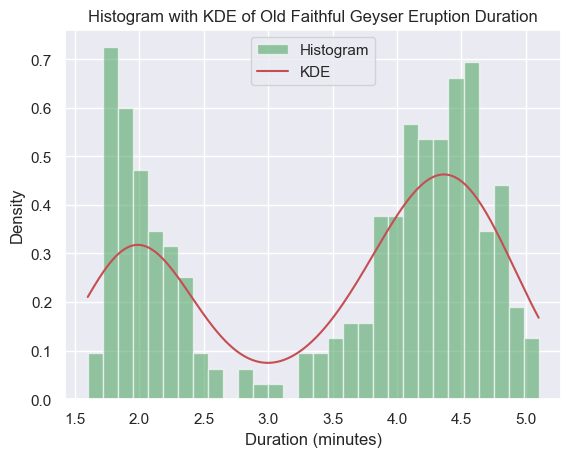

In [4]:
plt.hist(data, bins= 30, density=True, alpha=0.6, color='g', label='Histogram')
plt.plot(x_vals, y_vals, color='r', label='KDE')
plt.title('Histogram with KDE of Old Faithful Geyser Eruption Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Density')
plt.legend()
plt.show()

$N(x;m,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}exp^{-\frac{(x-m)^2}{2\sigma^2}}$

In [5]:
def gaussian_pdf(x, mu, sigma2):
    """ Gaussian probability density function """
    return (1.0 / np.sqrt(2 * np.pi * sigma2)) * np.exp(- (x - mu)**2 / (2 * sigma2))

The EM algorithm is an iterative algorithm that alternates between two steps:
1. E-step: calculate the expected value of the log-likelihood function, treating the latent variables as random variables.
2. M-step: maximize the expected value found on the E-step with respect to the model parameters.
3. Repeat until convergence.
4. The EM algorithm is guaranteed to converge to a local maximum of the likelihood function.

In [6]:
def em_gmm_1d(data, n_iterations=100, tol=1e-4):
    """ Fit a GMM with 2 Gaussians to 1D data using the EM algorithm """

    # Initialize
    mu = np.array([np.min(data), np.max(data)])
    sigma2 = np.array([1.0, 1.0])
    pi = 0.5
    N = len(data)

    for iteration in range(n_iterations):
        # E-step: calculate responsibilities
        w1 = pi * gaussian_pdf(data, mu[0], sigma2[0])
        w2 = (1.0 - pi) * gaussian_pdf(data, mu[1], sigma2[1])

        # normalize weights
        W = w1 + w2
        w1 /= W
        w2 /= W

        # M-step: update parameters
        mu[0] = np.sum(w1 * data) / np.sum(w1)
        mu[1] = np.sum(w2 * data) / np.sum(w2)
        sigma2[0] = np.sum(w1 * (data - mu[0])**2) / np.sum(w1)
        sigma2[1] = np.sum(w2 * (data - mu[1])**2) / np.sum(w2)
        pi = np.mean(w1)

        # compute log-likelihood and check for convergence
        log_likelihood = np.sum(np.log(W))
        if iteration > 0 and np.abs(log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = log_likelihood

    return mu, sigma2, pi

In [7]:
mu, sigma2, pi = em_gmm_1d(data)

(b) Try the fitting with different initialisations and visualise the estimation results. Show both an example when the algorithm converges to a good solution and when it fails. Can you explain why it fails sometimes?

In [24]:
np.random.seed(0) # for reproducibility

# Good initialization
mu = np.array([np.percentile(data, 25), np.percentile(data, 75)])
sigma2 = np.array([1.0, 1.0])
pi = 0.5

mu_good, sigma2_good, pi_good = em_gmm_1d(data)

In [27]:
# Bad initialization
mu = np.array([np.mean(data), np.mean(data) + 2])
sigma2 = np.array([2.0, 2.0])
pi = 0.5

mu_bad, sigma2_bad, pi_bad = em_gmm_1d(data)

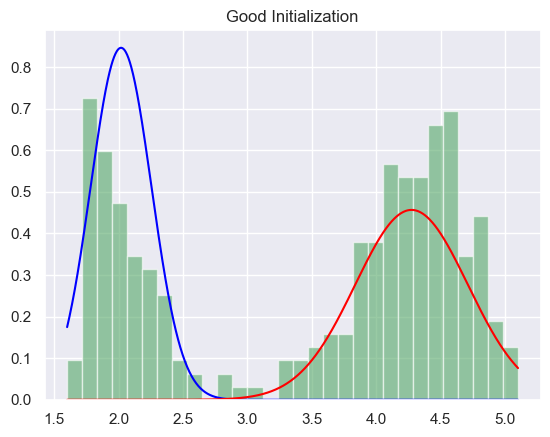

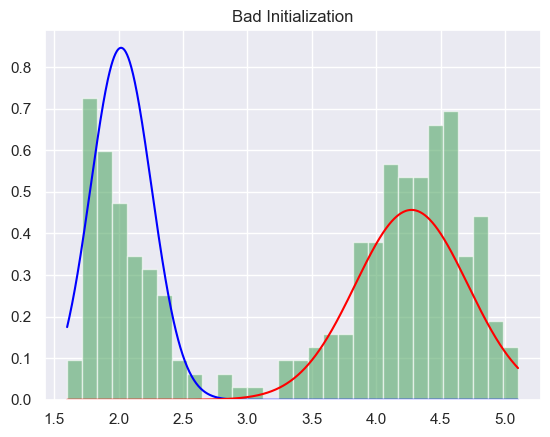

In [28]:
# Visualization function
def plot_gmm(data, mu, sigma2, title):
    x = np.linspace(min(data), max(data), 1000)
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
    plt.plot(x, pi * gaussian_pdf(x, mu[0], sigma2[0]), color='blue')
    plt.plot(x, (1-pi) * gaussian_pdf(x, mu[1], sigma2[1]), color='red')
    plt.title(title)
    plt.show()

# Plotting
plot_gmm(data, mu_good, sigma2_good, "Good Initialization")
plot_gmm(data, mu_bad, sigma2_bad, "Bad Initialization")

The EM algorithm, like many optimization algorithms, is sensitive to initialization. If the two Gaussians are initialized too close to each other, the algorithm might converge to a local maximum of the likelihood, effectively identifying only one cluster in the data. Since the EM algorithm only refines the initial guess, it can sometimes get stuck if that guess is too far from the truth. That's why using domain knowledge, data exploration, or multiple initializations followed by choosing the result with the highest likelihood is essential.